In [ ]:
import os
os.environ['OPENAI_API_KEY'] = "EXAMPLE"

In [ ]:
!pip install langchain_community

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.8/276.8 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.5/87.5 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.8/144.8 kB 18.9 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
      Successfully uninstalled packaging-24.0


In [ ]:
!pip install langchain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.8/812.8 kB 10.1 MB/s eta 0:00:00


# 리트리버
##### 많은 LLM 애플리케이션에 모델 교육 세트가 아닌 사용자 데이터가 필요하다.
##### 이를 위해 검색 증강 생성(RAG)를 이용하는데, 이 과정에서 외부 데이터를 검색 한 후 생성 단계를 수행할 때 LLM으로 전달한다.
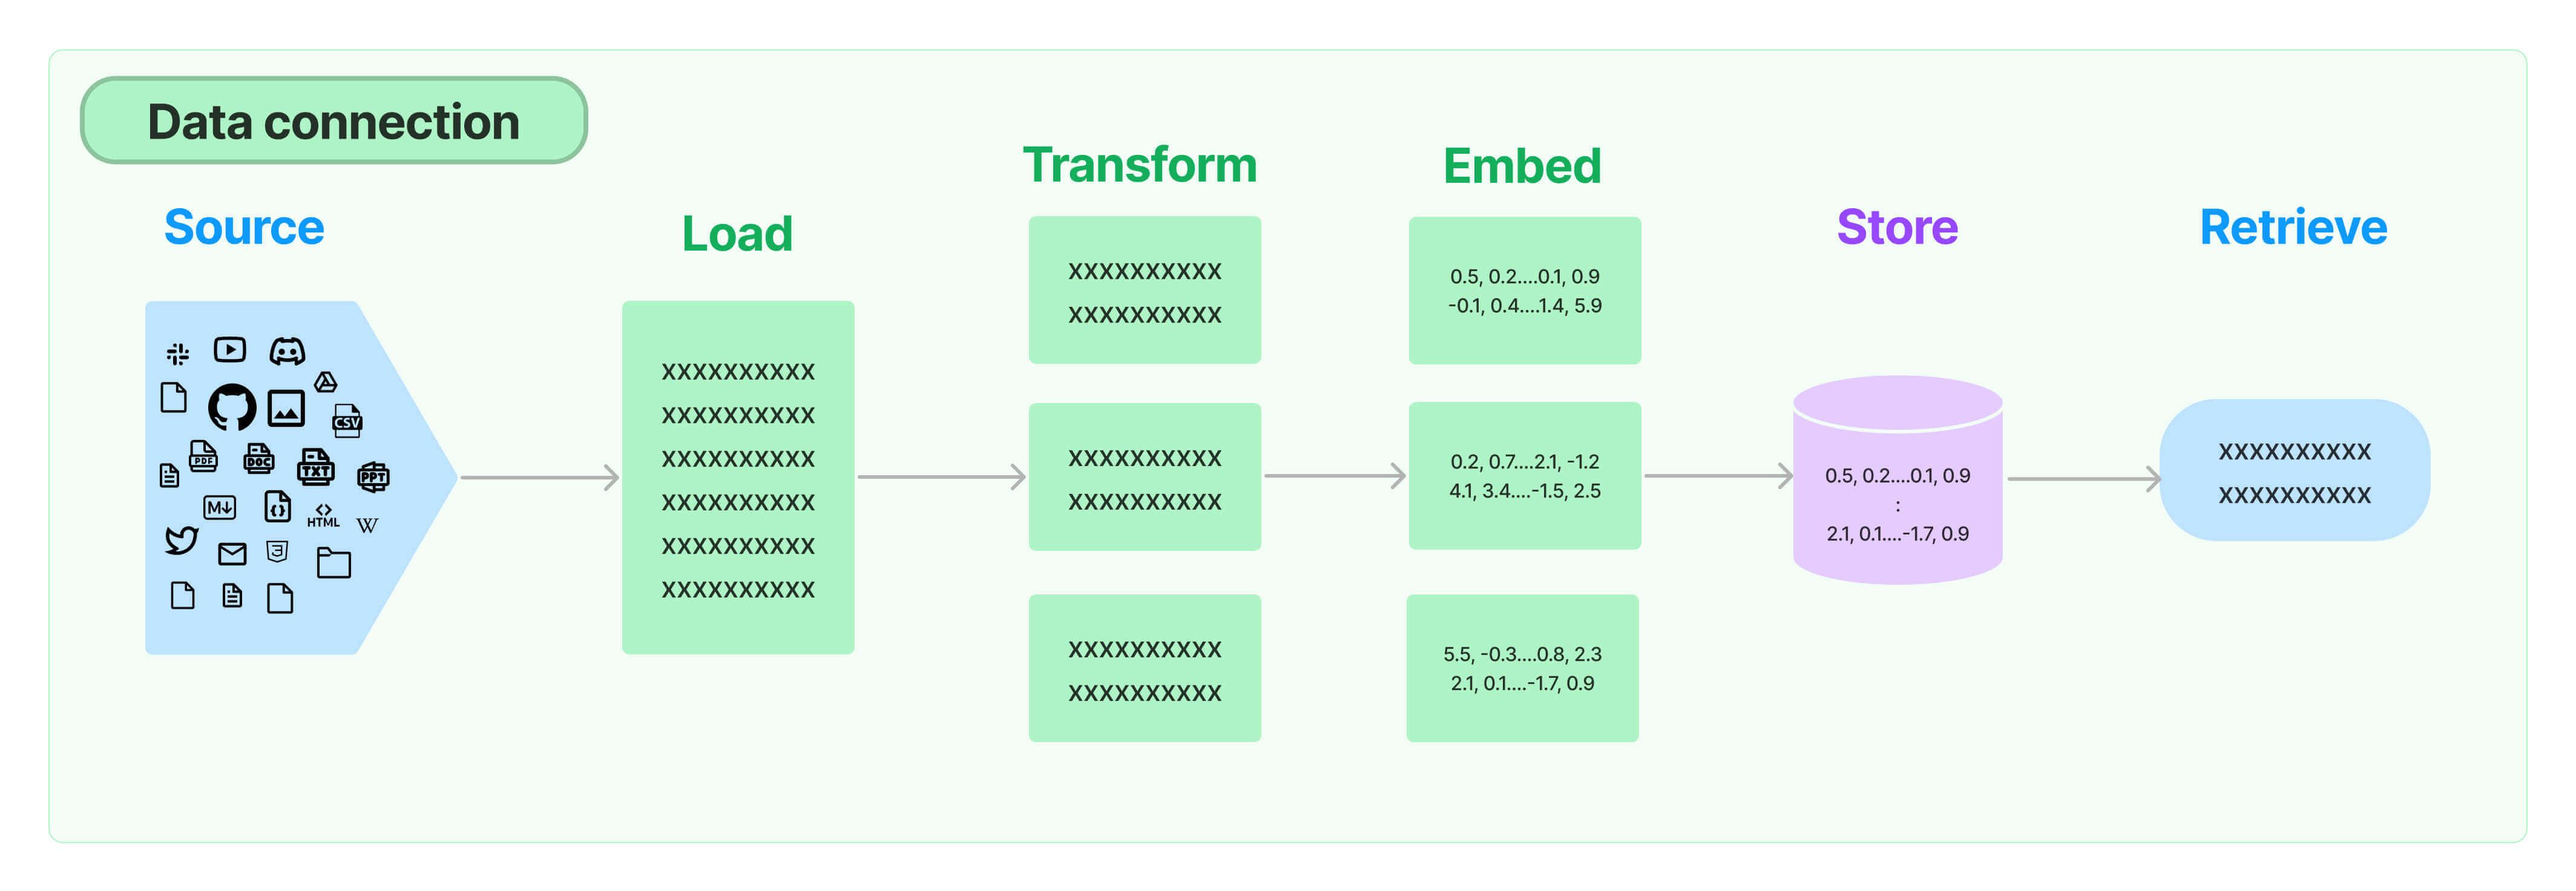

## 문서 로더
##### 문서 로더를 사용하여 소스의 데이터를 Document 로드한다.
##### Document는 텍스트 및 관련 메타데이터이다.

### 시작하기
##### 가장 간단한 로더는 파일을 텍스트로 읽고 이를 모두 하나의 문서에 배치한다.

In [ ]:
cd /content/drive/MyDrive/Colab Notebooks/langchainsawman/week4

/content/drive/MyDrive/Colab Notebooks/langchainsawman/week4


In [ ]:
from langchain_community.document_loaders import TextLoader

loader = TextLoader("markdown-sample.md")
loader.load()

[Document(page_content='An h1 header\n============\n\nParagraphs are separated by a blank line.\n\n2nd paragraph. *Italic*, **bold**, and `monospace`. Itemized lists\nlook like:\n\n  * this one\n  * that one\n  * the other one\n\nNote that --- not considering the asterisk --- the actual text\ncontent starts at 4-columns in.\n\n> Block quotes are\n> written like so.\n>\n> They can span multiple paragraphs,\n> if you like.\n\nUse 3 dashes for an em-dash. Use 2 dashes for ranges (ex., "it\'s all\nin chapters 12--14"). Three dots ... will be converted to an ellipsis.\nUnicode is supported. ☺\n\n\n\nAn h2 header\n------------\n\nHere\'s a numbered list:\n\n 1. first item\n 2. second item\n 3. third item\n\nNote again how the actual text starts at 4 columns in (4 characters\nfrom the left side). Here\'s a code sample:\n\n    # Let me re-iterate ...\n    for i in 1 .. 10 { do-something(i) }\n\nAs you probably guessed, indented 4 spaces. By the way, instead of\nindenting the block, you can use

## 사용자 정의 문서 로더
##### LLM 기반 응용 프로그램에는 PDF와 같은 데이터베이스나 파일에서 데이터를 추출하고 이를 LLM이 활용할 수 있는 형식으로 변환하는 작업이 수반된다.
##### Langchain에서는 일반적으로 추출된 텍스트(page_content)를 메타데이터와 함께 캡슐화하는 Document 개체를 생성하는 작업이 포함된다.
##### Document 개체는 종종 LLM에 제공되는 프롬프트로 형식화되어 LLM이 Document에서 원하는 응답을 생성하기 위해 정보를 사용할 수 있다.
##### Document 로딩의 주요 추상화는 아래와 같다.


*   Document : text와 metadata가 포함된다
*   BaseDocumentLoader : 원시 데이터를 Documents 개체로 변환하는데 사용한다
*   Blob : 파일이나 메모리에 있는 이진 데이터의 표현이다
*   BaseBlobParser : Docuemnt 객체를 생성하기 위해 Blob를 파싱하는 로직이다


##### 아래 예제에서 사용자 정의 문서 로딩 및 파일 구문 분석 논리를 작성하는 방법을 소개한다.


1.  BasedLoader에서 하위 분류하여 표준 문서 로더를 만든다.
2.  BaseBlobParser를 사용하여 파서를 만들고, Blob와 BlobLoaders를 결합하여 사용한다. 이것은 파일 처리할 때 매우 유용하다.



### 표준 문서 로더
##### 문서 로더는 문서 로드를 위한 표준 인터페이스를 제공하는 BaseLoader에서 하위 클래스를 생성하여 구현할 수 있다.
##### 해당 인터페이스는 아래와 같다.


*   lazy_load : 문서를 하나씩 천천히 로드에 사용. production code level
*   alazy_load : 비동기 lazy_load
*   load : 모든 문서를 메모리에 로드함. prototype/conversation level
*   aload : 비동기 load

##### load는 프로토타입 작업에만 사용되는 메서드.
##### 비동기를 사용하는 경우 기본 구현을 재정의하고 기본 비동기 구현을 제공하는게 좋다

##### *주의 : 문서 로더를 구현할 때 (lazy_load, alazy_load) 메소드를 통해 매개변수를 제공하지 마라!



##### 파일을 로드하고 파일의 각 줄에서 문서를 생성하는 표준 문서 로더를 만들어보자

In [ ]:
!pip install aiofiles

In [ ]:
from typing import AsyncIterator, Iterator

from langchain_core.document_loaders import BaseLoader
from langchain_core.documents import Document


class CustomDocumentLoader(BaseLoader):
    """An example document loader that reads a file line by line."""

    def __init__(self, file_path: str) -> None:
        """Initialize the loader with a file path.

        Args:
            file_path: The path to the file to load.
        """
        self.file_path = file_path

    def lazy_load(self) -> Iterator[Document]:  # <-- 매개변수 x
        """A lazy loader that reads a file line by line.

        When you're implementing lazy load methods, you should use a generator
        to yield documents one by one.
        """
        with open(self.file_path, encoding="utf-8") as f:
            line_number = 0
            for line in f:
                yield Document(
                    page_content=line,
                    metadata={"line_number": line_number, "source": self.file_path},
                )
                line_number += 1

    # alazy_load는 선택
    # 구현을 생략하면, lazy_load에는 alazy_load 의 기본 구현이 위임된다.
    async def alazy_load(
        self,
    ) -> AsyncIterator[Document]:  # <-- 매개변수 필요없음
        """An async lazy loader that reads a file line by line."""
        # Requires aiofiles
        #`pip install aiofiles`
        import aiofiles

        async with aiofiles.open(self.file_path, encoding="utf-8") as f:
            line_number = 0
            async for line in f:
                yield Document(
                    page_content=line,
                    metadata={"line_number": line_number, "source": self.file_path},
                )
                line_number += 1

##### 문서 로드를 테스트하려면 품질이 좋은 콘텐츠가 포함된 파일이 필요하다.

In [ ]:
with open("./meow.txt", "w", encoding="utf-8") as f:
    quality_content = "meow meow🐱 \n meow meow🐱 \n meow😻😻"
    f.write(quality_content)

loader = CustomDocumentLoader("./meow.txt")

In [ ]:
loader

In [ ]:
# lazy_load 수행
for doc in loader.lazy_load():
  print()
  print(type(doc))
  print(doc)


<class 'langchain_core.documents.base.Document'>
page_content='meow meow🐱 \n' metadata={'line_number': 0, 'source': './meow.txt'}

<class 'langchain_core.documents.base.Document'>
page_content=' meow meow🐱 \n' metadata={'line_number': 1, 'source': './meow.txt'}

<class 'langchain_core.documents.base.Document'>
page_content=' meow😻😻' metadata={'line_number': 2, 'source': './meow.txt'}


In [ ]:
# alazy_load 수행
async for doc in loader.alazy_load():
  print()
  print(type(doc))
  print(doc)


<class 'langchain_core.documents.base.Document'>
page_content='meow meow🐱 \n' metadata={'line_number': 0, 'source': './meow.txt'}

<class 'langchain_core.documents.base.Document'>
page_content=' meow meow🐱 \n' metadata={'line_number': 1, 'source': './meow.txt'}

<class 'langchain_core.documents.base.Document'>
page_content=' meow😻😻' metadata={'line_number': 2, 'source': './meow.txt'}


In [ ]:
loader.load()

[Document(page_content='meow meow🐱 \n', metadata={'line_number': 0, 'source': './meow.txt'}),
 Document(page_content=' meow meow🐱 \n', metadata={'line_number': 1, 'source': './meow.txt'}),
 Document(page_content=' meow😻😻', metadata={'line_number': 2, 'source': './meow.txt'})]

### 파일 작업
##### 많은 문서 로더는 구문 분석 파일을 사용한다. 예를 들어, open의 경우 PDF 또는 md 파일의 이진 콘텐츠를 읽는데 사용 가능하지만 해당 이진 데이터를 텍스트로 변환할려면 다른 구문 분석 논리가 필요한 것이다.
##### 결과적으로, 로딩 과정에서 구분 분석 로직을 분리하면 데이터가 로드된 방식에 관계없이 주어지 파서를 재사용하기가 더 쉬워진다

#### BaseBlobParser
##### BaseBlobParser는 blob를 받아들이고, Document 객체 목록을 출력하는 인터페이스이다.

In [ ]:
from langchain_core.document_loaders import BaseBlobParser, Blob


class MyParser(BaseBlobParser):
    """A simple parser that creates a document from each line."""

    def lazy_parse(self, blob: Blob) -> Iterator[Document]:
        """Parse a blob into a document line by line."""
        line_number = 0
        with blob.as_bytes_io() as f:
            for line in f:
                line_number += 1
                yield Document(
                    page_content=line,
                    metadata={"line_number": line_number, "source": blob.source},
                )

In [ ]:
blob = Blob.from_path("./meow.txt")
parser = MyParser()

In [ ]:
list(parser.lazy_parse(blob))

[Document(page_content='meow meow🐱 \n', metadata={'line_number': 1, 'source': './meow.txt'}),
 Document(page_content=' meow meow🐱 \n', metadata={'line_number': 2, 'source': './meow.txt'}),
 Document(page_content=' meow😻😻', metadata={'line_number': 3, 'source': './meow.txt'})]

##### Blob API를 사용하면 파일에서 콘텐츠를 읽지 않고도 메모리에서 콘텐츠를 직접 로드 할 수 있다

In [ ]:
blob = Blob(data=b"some data from memory\nmeow")
list(parser.lazy_parse(blob))

[Document(page_content='some data from memory\n', metadata={'line_number': 1, 'source': None}),
 Document(page_content='meow', metadata={'line_number': 2, 'source': None})]

In [ ]:
blob = Blob.from_path("./meow.txt", metadata={"foo": "bar"})

In [ ]:
blob.encoding

'utf-8'

In [ ]:
blob.as_bytes()

b'meow meow\xf0\x9f\x90\xb1 \n meow meow\xf0\x9f\x90\xb1 \n meow\xf0\x9f\x98\xbb\xf0\x9f\x98\xbb'

In [ ]:
blob.as_string()

'meow meow🐱 \n meow meow🐱 \n meow😻😻'

In [ ]:
blob.as_bytes_io()

In [ ]:
blob.metadata

{'foo': 'bar'}

In [ ]:
blob.source

'./meow.txt'

#### Blob 로더
##### 파서는 이진 데이터를 문서로 구문 분석하는 데 필요한 논리를 캡슐화하는 반면, Blob 로더는 지정된 저장소 위치에서 Blob을 로드하는 데 필요한 논리를 캡슐화한다.
##### langchain에서는 FileSystemBlobLoader를 사용한다.

In [ ]:
from langchain_community.document_loaders.blob_loaders import FileSystemBlobLoader

blob_loader = FileSystemBlobLoader(path=".", glob="*.md", show_progress=True)

In [ ]:
parser = MyParser()
for blob in blob_loader.yield_blobs():
    for doc in parser.lazy_parse(blob):
        print(doc)
        break

  0%|          | 0/1 [00:00<?, ?it/s]

page_content='An h1 header\n' metadata={'line_number': 1, 'source': 'markdown-sample.md'}


#### 일반 로더
##### GenericLoader를 사용한다. 하지만 현재는 FileSystemBlobLoader만 지원된다.

```python
from langchain_community.document_loaders.generic import GenericLoader
```

## CSV
##### CSV는 쉼표를 사용하여 값을 구분하는 구분된 텍스트 파일이다.
##### 문서당 단일 행으로 CSV 데이터를 로드한다.

In [ ]:
from langchain_community.document_loaders.csv_loader import CSVLoader

loader = CSVLoader(file_path='mlb_teams_2012.csv')
data = loader.load()

In [ ]:
print(data)

[Document(page_content='Team: Nationals\n"Payroll (millions)": 81.34\n"Wins": 98', metadata={'source': 'mlb_teams_2012.csv', 'row': 0}), Document(page_content='Team: Reds\n"Payroll (millions)": 82.20\n"Wins": 97', metadata={'source': 'mlb_teams_2012.csv', 'row': 1}), Document(page_content='Team: Yankees\n"Payroll (millions)": 197.96\n"Wins": 95', metadata={'source': 'mlb_teams_2012.csv', 'row': 2}), Document(page_content='Team: Giants\n"Payroll (millions)": 117.62\n"Wins": 94', metadata={'source': 'mlb_teams_2012.csv', 'row': 3}), Document(page_content='Team: Braves\n"Payroll (millions)": 83.31\n"Wins": 94', metadata={'source': 'mlb_teams_2012.csv', 'row': 4}), Document(page_content='Team: Athletics\n"Payroll (millions)": 55.37\n"Wins": 94', metadata={'source': 'mlb_teams_2012.csv', 'row': 5}), Document(page_content='Team: Rangers\n"Payroll (millions)": 120.51\n"Wins": 93', metadata={'source': 'mlb_teams_2012.csv', 'row': 6}), Document(page_content='Team: Orioles\n"Payroll (millions)":

### CSV 파싱 및 로딩
##### 자세한 내용은 CSV 모듈 설명서 참고(https://docs.python.org/3/library/csv.html)

In [ ]:
loader = CSVLoader(file_path='mlb_teams_2012.csv', csv_args={
    'delimiter': ',',
    'quotechar': '"',
    'fieldnames': ['MLB Team', 'Payroll in millions', 'Wins']
})

data = loader.load()

In [ ]:
print(data)

[Document(page_content='MLB Team: Team\nPayroll in millions: "Payroll (millions)"\nWins: "Wins"', metadata={'source': 'mlb_teams_2012.csv', 'row': 0}), Document(page_content='MLB Team: Nationals\nPayroll in millions: 81.34\nWins: 98', metadata={'source': 'mlb_teams_2012.csv', 'row': 1}), Document(page_content='MLB Team: Reds\nPayroll in millions: 82.20\nWins: 97', metadata={'source': 'mlb_teams_2012.csv', 'row': 2}), Document(page_content='MLB Team: Yankees\nPayroll in millions: 197.96\nWins: 95', metadata={'source': 'mlb_teams_2012.csv', 'row': 3}), Document(page_content='MLB Team: Giants\nPayroll in millions: 117.62\nWins: 94', metadata={'source': 'mlb_teams_2012.csv', 'row': 4}), Document(page_content='MLB Team: Braves\nPayroll in millions: 83.31\nWins: 94', metadata={'source': 'mlb_teams_2012.csv', 'row': 5}), Document(page_content='MLB Team: Athletics\nPayroll in millions: 55.37\nWins: 94', metadata={'source': 'mlb_teams_2012.csv', 'row': 6}), Document(page_content='MLB Team: Rang

### 문서 소스를 식별하기 위한 컬럼 특정화
##### source_column 인수를 사용하여 각 행에서 생성된 문서의 소스를 지정한다. 그렇지 않으면 csv 파일에서 생성된 모든 문서의 소스로 사용된다
##### 이는 소스를 사용하여 질문에 답변하는 체인에 대해 csv 파일에서 로드된 문서를 사용할 때 유용하다

In [ ]:
loader = CSVLoader(file_path='mlb_teams_2012.csv', source_column="Team")

data = loader.load()

In [ ]:
print(data)

[Document(page_content='Team: Nationals\n"Payroll (millions)": 81.34\n"Wins": 98', metadata={'source': 'Nationals', 'row': 0}), Document(page_content='Team: Reds\n"Payroll (millions)": 82.20\n"Wins": 97', metadata={'source': 'Reds', 'row': 1}), Document(page_content='Team: Yankees\n"Payroll (millions)": 197.96\n"Wins": 95', metadata={'source': 'Yankees', 'row': 2}), Document(page_content='Team: Giants\n"Payroll (millions)": 117.62\n"Wins": 94', metadata={'source': 'Giants', 'row': 3}), Document(page_content='Team: Braves\n"Payroll (millions)": 83.31\n"Wins": 94', metadata={'source': 'Braves', 'row': 4}), Document(page_content='Team: Athletics\n"Payroll (millions)": 55.37\n"Wins": 94', metadata={'source': 'Athletics', 'row': 5}), Document(page_content='Team: Rangers\n"Payroll (millions)": 120.51\n"Wins": 93', metadata={'source': 'Rangers', 'row': 6}), Document(page_content='Team: Orioles\n"Payroll (millions)": 81.43\n"Wins": 93', metadata={'source': 'Orioles', 'row': 7}), Document(page_

## 파일 디렉토리
##### 디렉토리의 모든 문서를 로드하는 방법을 알아보자(내부적으로는 UnstructedLoader를 사용)

In [ ]:
!pip install unstructured

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.8/433.8 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.7/274.7 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 33.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 46.5 MB/s eta 0:00:00
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993227 sha256=26dd8f0b265fbd29314513357eb37f6a75c8b543da5c15ac5d0b5d364f8c488b
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [ ]:
from langchain_community.document_loaders import DirectoryLoader

##### glob 매개변수를 사용하여 로드할 파일을 제어 할 수 있다.

In [ ]:
loader = DirectoryLoader('../', glob="**/*.md")

In [ ]:
docs = loader.load()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
print(len(docs))

1


### 진행률 표시
##### 진행률을 표시하려면 tqdm 라이브러리를 설치하고, show_progress 매개변수를 True로 설정한다.

In [ ]:
!pip install tqdm

In [ ]:
loader = DirectoryLoader('../', glob="**/*.md", show_progress=True)
docs = loader.load()

100%|██████████| 1/1 [00:00<00:00, 20.91it/s]


### 멀티스레딩 사용
##### 기본적으로 로딩은 하나의 스레드에서 발생한다. 여러 스레드를 활용하려면 use_multithreading을 True로 설정한다

In [ ]:
loader = DirectoryLoader('', glob="**/*.md", use_multithreading=True)
docs = loader.load()

### 로더 클래스
##### 기본적으로 UnstructedLoader 클래스를 사용하는데, 로더 유형을 매우 쉽게 변경할 수 있다.

In [ ]:
from langchain_community.document_loaders import TextLoader

In [ ]:
loader = DirectoryLoader('../', glob="**/*.md", loader_cls=TextLoader)

In [ ]:
docs = loader.load()
print(len(docs))

1


##### PythonLoader : Python 소스 코드 파일을 로드해야 하는 경우

In [ ]:
from langchain_community.document_loaders import PythonLoader

In [ ]:
loader = DirectoryLoader('', glob="**/*.py", loader_cls=PythonLoader)

In [ ]:
docs = loader.load()
print(len(docs))

2


### TextLoader를 사용하여 파일 인코딩 자동 감지

#### 일반적인 경우
##### 문서 로드 실패시 기본 동작으로 인해 전체 로드 프로세스가 실패하고 문서가 로드되지 않는다

In [ ]:
path = ''
loader = DirectoryLoader(path, glob="**/*.txt", loader_cls=TextLoader)
loader.load()

[Document(page_content='1/22/23, 6:30 PM - User 1: Hi! Im interested in your bag. Im offering $50. Let me know if you are interested. Thanks!\n1/22/23, 8:24 PM - User 2: Goodmorning! $50 is too low.\n1/23/23, 2:59 AM - User 1: How much do you want?\n1/23/23, 3:00 AM - User 2: Online is at least $100\n1/23/23, 3:01 AM - User 2: Here is $129\n1/23/23, 3:01 AM - User 2: <Media omitted>\n1/23/23, 3:01 AM - User 1: Im not interested in this bag. Im interested in the blue one!\n1/23/23, 3:02 AM - User 1: I thought you were selling the blue one!\n1/23/23, 3:18 AM - User 2: No Im sorry it was my mistake, the blue one is not for sale\n1/23/23, 3:19 AM - User 1: Oh no worries! Bye\n1/23/23, 3:19 AM - User 2: Bye!\n1/23/23, 3:22_AM - User 1: And let me know if anything changes', metadata={'source': 'whatsapp_chat.txt'}),
 Document(page_content='meow meow🐱 \n meow meow🐱 \n meow😻😻', metadata={'source': 'meow.txt'}),
 Document(page_content='      application.json\n    1023495323659816971/\n  applica

#### 자동 실패
##### silent_errors 매개변수를 전달하여 DirectoryLoader에서 로드할 수 없는 파일을 건너뛰고 로드 프로세스를 계속할 수 있다.

In [ ]:
loader = DirectoryLoader('', glob="**/*.txt", loader_cls=TextLoader, silent_errors=True)
docs = loader.load()

In [ ]:
doc_sources = [doc.metadata['source']  for doc in docs]
doc_sources

['whatsapp_chat.txt', 'meow.txt', 'fake_discord_data/output.txt']

#### 자동 인코딩
##### 로더 클래스에 autodetect_encoding을 전달하여 실패하기 전에 파일 인코딩을 자동 감지하도록 요청할 수 있다.

In [ ]:
text_loader_kwargs={'autodetect_encoding': True}
loader = DirectoryLoader('', glob="**/*.txt", loader_cls=TextLoader, loader_kwargs=text_loader_kwargs)
docs = loader.load()

In [ ]:
doc_sources = [doc.metadata['source']  for doc in docs]
doc_sourgces

['whatsapp_chat.txt', 'meow.txt', 'fake_discord_data/output.txt']

## HTML
##### 다운스트림에서 사용할 수 있는 문서 형식으로 HTML 문서를 로드하는 방법을 다룬다.

In [ ]:
from langchain_community.document_loaders import UnstructuredHTMLLoader

loader = UnstructuredHTMLLoader("fake-content.html")

In [ ]:
data = loader.load()

In [ ]:
data

[Document(page_content='My First Heading\n\nMy first paragraph.', metadata={'source': 'fake-content.html'})]

### BeautifulSoup4로 HTML 로딩
##### BSHTMLLoader를 사용하여 HTML 문서를 로드할 수 있다.
##### 이렇게 하면 HTML의 텍스트가 page_content로 추출되고 페이지 제목이 title로 추출된다.

In [ ]:
from langchain_community.document_loaders import BSHTMLLoader

loader = BSHTMLLoader("fake-content.html")
data = loader.load()
data

[Document(page_content='\nTest Title\n\n\nMy First Heading\nMy first paragraph.\n\n\n', metadata={'source': 'fake-content.html', 'title': 'Test Title'})]

### Azure AI Document Intelligence 를 사용하여 HTML 로드
##### Azure AI Document Intelligence는 디지털 또는 스캔한 PDF에서 텍스트, 표, 문서 구조 및 키-값 쌍을 추출하는 기계 학습 기반 서비스이다.
##### Document Intelligence를 사용하는 로더의 현재 구현은 콘텐츠 페이지를 통합하고 이를 Langchain 문서로 변환할 수 있다.
##### 기본 출력 형식은 의미론적 문서 청크를 위해 MarkdownHeaderTextSplitter와 함께 쉽게 연결할 수 있는 마크다운이다.
##### 단일 페이지나 페이지별로 분할된 문서에서 mode="single"이나 mode="page"를 사용하여 순수 텍스트를 반환할 수 있다.

In [ ]:
!pip install --upgrade --quiet  langchain langchain-community azure-ai-documentintelligence

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.4/193.4 kB 8.8 MB/s eta 0:00:00


In [ ]:
from langchain_community.document_loaders import AzureAIDocumentIntelligenceLoader

file_path = "<filepath>"
endpoint = "<endpoint>"
key = "<key>"
loader = AzureAIDocumentIntelligenceLoader(
    api_endpoint=endpoint, api_key=key, file_path=file_path, api_model="prebuilt-layout"
)

documents = loader.load()

## JSON
##### JSON은 사람이 읽을 수 있는 텍스트를 사용하여 속성-값 쌍과 배열로 구성된 데이터 객체를 저장하고 전송하는 개방형 표준 파일 형식 및 데이터 교환 형식이다.
##### 지정된 jq 스키마를 사용하여 JSON 파일을 구문 분석한다. (JSONLoader)

In [ ]:
!pip install jq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.6/657.6 kB 8.7 MB/s eta 0:00:00


In [ ]:
from langchain_community.document_loaders import JSONLoader

In [ ]:
import json
from pathlib import Path
from pprint import pprint


file_path='facebook_chat.json'
data = json.loads(Path(file_path).read_text())

In [ ]:
pprint(data)

{'image': {'creation_timestamp': 1675549016, 'uri': 'image_of_the_chat.jpg'},
 'is_still_participant': True,
 'joinable_mode': {'link': '', 'mode': 1},
 'magic_words': [],
 'messages': [{'content': 'Bye!',
               'sender_name': 'User 2',
               'timestamp_ms': 1675597571851},
              {'content': 'Oh no worries! Bye',
               'sender_name': 'User 1',
               'timestamp_ms': 1675597435669},
              {'content': 'No Im sorry it was my mistake, the blue one is not '
                          'for sale',
               'sender_name': 'User 2',
               'timestamp_ms': 1675596277579},
              {'content': 'I thought you were selling the blue one!',
               'sender_name': 'User 1',
               'timestamp_ms': 1675595140251},
              {'content': 'Im not interested in this bag. Im interested in the '
                          'blue one!',
               'sender_name': 'User 1',
               'timestamp_ms': 1675595109305},
   

### JSONLoader 사용

#### JSON FILE
##### content 내 필드 아래의 값을 추출하는 데 관심있다고 할때, message 를 통해 쉽게 할 수 있다.

In [ ]:
loader = JSONLoader(
    file_path='facebook_chat.json',
    jq_schema='.messages[].content',
    text_content=False)

data = loader.load()

In [ ]:
pprint(data)

[Document(page_content='Bye!', metadata={'source': '/content/drive/MyDrive/Colab Notebooks/langchainsawman/week4/facebook_chat.json', 'seq_num': 1}),
 Document(page_content='Oh no worries! Bye', metadata={'source': '/content/drive/MyDrive/Colab Notebooks/langchainsawman/week4/facebook_chat.json', 'seq_num': 2}),
 Document(page_content='No Im sorry it was my mistake, the blue one is not for sale', metadata={'source': '/content/drive/MyDrive/Colab Notebooks/langchainsawman/week4/facebook_chat.json', 'seq_num': 3}),
 Document(page_content='I thought you were selling the blue one!', metadata={'source': '/content/drive/MyDrive/Colab Notebooks/langchainsawman/week4/facebook_chat.json', 'seq_num': 4}),
 Document(page_content='Im not interested in this bag. Im interested in the blue one!', metadata={'source': '/content/drive/MyDrive/Colab Notebooks/langchainsawman/week4/facebook_chat.json', 'seq_num': 5}),
 Document(page_content='Here is $129', metadata={'source': '/content/drive/MyDrive/Colab

#### JSON Lines file
##### 만약 당신은 JSON Lines 파일에서 docuents를 로드하길 원한다면, json_lines=True 설정과 단일 json 객체로부터 page_content를 추출하기 위해 jq_schema를 구체화해야 한다.

In [ ]:
file_path = 'facebook_chat_messages.jsonl'
pprint(Path(file_path).read_text())

('{"sender_name": "User 2", "timestamp_ms": 1675597571851, "content": "Bye!"}\n'
 '{"sender_name": "User 1", "timestamp_ms": 1675597435669, "content": "Oh no '
 'worries! Bye"}\n'
 '{"sender_name": "User 2", "timestamp_ms": 1675596277579, "content": "No Im '
 'sorry it was my mistake, the blue one is not for sale"}\n')


In [ ]:
loader = JSONLoader(
    file_path='facebook_chat_messages.jsonl',
    jq_schema='.content',
    text_content=False,
    json_lines=True)

data = loader.load()

In [ ]:
pprint(data)

[Document(page_content='Bye!', metadata={'source': '/content/drive/MyDrive/Colab Notebooks/langchainsawman/week4/facebook_chat_messages.jsonl', 'seq_num': 1}),
 Document(page_content='Oh no worries! Bye', metadata={'source': '/content/drive/MyDrive/Colab Notebooks/langchainsawman/week4/facebook_chat_messages.jsonl', 'seq_num': 2}),
 Document(page_content='No Im sorry it was my mistake, the blue one is not for sale', metadata={'source': '/content/drive/MyDrive/Colab Notebooks/langchainsawman/week4/facebook_chat_messages.jsonl', 'seq_num': 3})]


##### 다른 방법으로는 jq_scehma='.' 설정과 content_key를 제공하는 것이다.

In [ ]:
loader = JSONLoader(
    file_path='facebook_chat_messages.jsonl',
    jq_schema='.',
    content_key='sender_name',
    json_lines=True)

data = loader.load()

In [ ]:
pprint(data)

[Document(page_content='User 2', metadata={'source': '/content/drive/MyDrive/Colab Notebooks/langchainsawman/week4/facebook_chat_messages.jsonl', 'seq_num': 1}),
 Document(page_content='User 1', metadata={'source': '/content/drive/MyDrive/Colab Notebooks/langchainsawman/week4/facebook_chat_messages.jsonl', 'seq_num': 2}),
 Document(page_content='User 2', metadata={'source': '/content/drive/MyDrive/Colab Notebooks/langchainsawman/week4/facebook_chat_messages.jsonl', 'seq_num': 3})]


### jq schema(content_key)와 JSON file 사용
##### jq 스키마 내의 content_key를 사용하여 JSON 파일에서 문서를 로드하려면 is_content_key_jq_parsable=True 설정해야 함.
##### 항상 content_key가 호환되고, jq 스키마를 사용하여 구문 분석될 수 있는지 확인해야 함

In [ ]:
file_path = 'sample.json'
pprint(Path(file_path).read_text())

('{"data": [\n'
 '    {"attributes": {\n'
 '        "message": "message1",\n'
 '        "tags": [\n'
 '        "tag1"]},\n'
 '    "id": "1"},\n'
 '    {"attributes": {\n'
 '        "message": "message2",\n'
 '        "tags": [\n'
 '        "tag2"]},\n'
 '    "id": "2"}]}')


In [ ]:
loader = JSONLoader(
    file_path=file_path,
    jq_schema=".data[]",
    content_key=".attributes.message",
    is_content_key_jq_parsable=True,
)

data = loader.load()

In [ ]:
pprint(data)

[Document(page_content='message1', metadata={'source': '/content/drive/MyDrive/Colab Notebooks/langchainsawman/week4/sample.json', 'seq_num': 1}),
 Document(page_content='message2', metadata={'source': '/content/drive/MyDrive/Colab Notebooks/langchainsawman/week4/sample.json', 'seq_num': 2})]


### 메타데이터 추출
##### 일반저긍로 우리는 JSON 파일에서 사용할 수 있는 메타데이터를 콘텐츠에서 생성하는 문서에 포함하려고 한다.
##### JSONLoader : 메타데이터 추출
##### 주의할 점


1.   메타데이터를 수집하지 않은 이전 예에서는 값을 추출할 수 있는 스키마에서 직접 지정(page_content) -> 현재 예에서는 로더에게 필드의 레코드를 반복하도록 지시해야 한다.
jq schema : .messages[].content -> .messages[]
2.   metadata_func를 통해 최종 객체에 저장된 메타데이터에 레코드의 어떤 정보가 포함되어야 하는지 담당한다.
3. 로더에서 인수를 통해 값을 추출해야하는 레코드의 키를 명시적으로 지정해야 한다.





In [ ]:
# Define the metadata extraction function.
def metadata_func(record: dict, metadata: dict) -> dict:

    metadata["sender_name"] = record.get("sender_name")
    metadata["timestamp_ms"] = record.get("timestamp_ms")

    return metadata


loader = JSONLoader(
    file_path='./example_data/facebook_chat.json',
    jq_schema='.messages[]',
    content_key="content",
    metadata_func=metadata_func
)

data = loader.load()

#### metadata_func 제어
##### 예를 들어, 기본 메타데이터에는 source 및 seq_num 키가 포함되어 있다고 했을 떄, JSON 데이터에도 이러한 키가 포함될 수 있다.
##### 그럼, 사용자는 이를 활용하여 metadata_func 기본 키의 이름을 바꾸고 JSON 데이터의 키를 사용할 수 있다.

In [ ]:
# Define the metadata extraction function.
def metadata_func(record: dict, metadata: dict) -> dict:

    metadata["sender_name"] = record.get("sender_name")
    metadata["timestamp_ms"] = record.get("timestamp_ms")

    if "source" in metadata:
        source = metadata["source"].split("/")
        source = source[source.index("langchain"):]
        metadata["source"] = "/".join(source)

    return metadata


loader = JSONLoader(
    file_path='facebook_chat.json',
    jq_schema='.messages[]',
    content_key="content",
    metadata_func=metadata_func
)

data = loader.load()

In [ ]:
pprint(data)

### jq 스키마와 JSON 구조

```python
JSON        -> [{"text": ...}, {"text": ...}, {"text": ...}]
jq_schema   -> ".[].text"

JSON        -> {"key": [{"text": ...}, {"text": ...}, {"text": ...}]}
jq_schema   -> ".key[].text"

JSON        -> ["...", "...", "..."]
jq_schema   -> ".[]"
```

## 마크다운
##### 마크다운은 일반 텍스트 편집기를 사용하여 서식 있는 텍스트를 만들기 위한 경량 마크업 언어다

In [ ]:
from langchain_community.document_loaders import UnstructuredMarkdownLoader

In [ ]:
markdown_path = "markdown-sample.md"
loader = UnstructuredMarkdownLoader(markdown_path)

In [ ]:
data = loader.load()

In [ ]:
print(data)

[Document(page_content='An h1 header\n\nParagraphs are separated by a blank line.\n\n2nd paragraph. Italic, bold, and monospace. Itemized lists\nlook like:\n\nthis one\n\nthat one\n\nthe other one\n\nNote that --- not considering the asterisk --- the actual text\ncontent starts at 4-columns in.\n\nBlock quotes are\nwritten like so.\n\nThey can span multiple paragraphs,\nif you like.\n\nUse 3 dashes for an em-dash. Use 2 dashes for ranges (ex., "it\'s all\nin chapters 12--14"). Three dots ... will be converted to an ellipsis.\nUnicode is supported. ☺\n\nAn h2 header\n\nHere\'s a numbered list:\n\nfirst item\n\nsecond item\n\nthird item\n\nNote again how the actual text starts at 4 columns in (4 characters\nfrom the left side). Here\'s a code sample:\n\nAs you probably guessed, indented 4 spaces. By the way, instead of\nindenting the block, you can use delimited blocks, if you like:\n\n~~~\ndefine foobar() {\n    print "Welcome to flavor country!";\n}\n~~~\n\n(which makes copying & pasti

### 요소 유지 및 분리
##### 기본적으로 Unstructured는 다양한 텍스트 덩어리에 대해 다양한 요소를 생성하는데, 기본적으로 함께 결합하지만 mode="elements"를 지정하여 쉽게 분리 유지할 수 있다.

In [ ]:
loader = UnstructuredMarkdownLoader(markdown_path, mode="elements")
data = loader.load()
data[0]

Document(page_content='An h1 header', metadata={'source': 'markdown-sample.md', 'last_modified': '2024-04-04T05:27:47', 'page_number': 1, 'languages': ['eng'], 'filetype': 'text/markdown', 'filename': 'markdown-sample.md', 'category': 'Title'})

## MS 오피스
### Azure AI Document Intelligence를 사용하여 DOCX, XLSX, PPTX 로드

In [ ]:
# %pip install --upgrade --quiet  langchain langchain-community azure-ai-documentintelligence

from langchain_community.document_loaders import AzureAIDocumentIntelligenceLoader

file_path = "<filepath>"
endpoint = "<endpoint>"
key = "<key>"
loader = AzureAIDocumentIntelligenceLoader(
    api_endpoint=endpoint, api_key=key, file_path=file_path, api_model="prebuilt-layout"
)

documents = loader.load()

## PDF
##### 다운스트림에서 사용하는 문서 형식으로 문서를 로드하는 방법을 다룬다.

### PyPDF 사용
##### PDF를 문서 배열로 로드한다. 각 문서에는 페이지 콘텐츠와 page 숫자가 포함된 메타데이터가 포함되어 있다.

In [ ]:
!pip install pypdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 6.2 MB/s eta 0:00:00


In [ ]:
!pip install -q langchain_openai
!pip install -q faiss-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 16.9 MB/s eta 0:00:00


In [ ]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader("layout-parser-paper.pdf")
pages = loader.load_and_split()

In [ ]:
print(pages[0])

page_content='LayoutParser : A Uniﬁed Toolkit for Deep\nLearning Based Document Image Analysis\nZejiang Shen1( \x00), Ruochen Zhang2, Melissa Dell3, Benjamin Charles Germain\nLee4, Jacob Carlson3, and Weining Li5\n1Allen Institute for AI\nshannons@allenai.org\n2Brown University\nruochen zhang@brown.edu\n3Harvard University\n{melissadell,jacob carlson }@fas.harvard.edu\n4University of Washington\nbcgl@cs.washington.edu\n5University of Waterloo\nw422li@uwaterloo.ca\nAbstract. Recent advances in document image analysis (DIA) have been\nprimarily driven by the application of neural networks. Ideally, research\noutcomes could be easily deployed in production and extended for further\ninvestigation. However, various factors like loosely organized codebases\nand sophisticated model conﬁgurations complicate the easy reuse of im-\nportant innovations by a wide audience. Though there have been on-going\neﬀorts to improve reusability and simplify deep learning (DL) model\ndevelopment in disciplin

##### 해당 접근 방식은 문서를 페이지 번호로 검색할 수 있다는 것이다.

In [ ]:
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings

faiss_index = FAISS.from_documents(pages, OpenAIEmbeddings())
docs = faiss_index.similarity_search("How will the community be engaged?", k=2)
for doc in docs:
    print(str(doc.metadata["page"]) + ":", doc.page_content[:300])

9: 10 Z. Shen et al.
Fig. 4: Illustration of (a) the original historical Japanese document with layout
detection results and (b) a recreated version of the document image that achieves
much better character recognition recall. The reorganization algorithm rearranges
the tokens based on the their detect
3: 4 Z. Shen et al.
Efficient Data AnnotationC u s t o m i z e d  M o d e l  T r a i n i n gModel Cust omizationDI A Model HubDI A Pipeline SharingCommunity PlatformLa y out Detection ModelsDocument Images 
T h e  C o r e  L a y o u t P a r s e r  L i b r a r yOCR ModuleSt or age & VisualizationLa y ou


### 이미지 추출
##### rapidocr-onnxruntime 패키지를 사용하면 이미지를 텍스트로도 추출할 수 있다

In [ ]:
!pip install -q rapidocr-onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 48.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 59.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 10.3 MB/s eta 0:00:00


In [ ]:
loader = PyPDFLoader("https://arxiv.org/pdf/2103.15348.pdf", extract_images=True)
pages = loader.load()
print(pages[4].page_content)

LayoutParser : A Uniﬁed Toolkit for DL-Based DIA 5
Table 1: Current layout detection models in the LayoutParser model zoo
Dataset Base Model1Large Model Notes
PubLayNet [38] F / M M Layouts of modern scientiﬁc documents
PRImA [3] M - Layouts of scanned modern magazines and scientiﬁc reports
Newspaper [17] F - Layouts of scanned US newspapers from the 20th century
TableBank [18] F F Table region on modern scientiﬁc and business document
HJDataset [31] F / M - Layouts of history Japanese documents
1For each dataset, we train several models of diﬀerent sizes for diﬀerent needs (the trade-oﬀ between accuracy
vs. computational cost). For “base model” and “large model”, we refer to using the ResNet 50 or ResNet 101
backbones [ 13], respectively. One can train models of diﬀerent architectures, like Faster R-CNN [ 28] (F) and Mask
R-CNN [ 12] (M). For example, an F in the Large Model column indicates it has a Faster R-CNN model trained
using the ResNet 101 backbone. The platform is maintained 

### MathPix 사용

In [ ]:
# MATHPIX_API_KEY 필요
from langchain_community.document_loaders import MathpixPDFLoader
loader = MathpixPDFLoader("layout-parser-paper.pdf")
data = loader.load()
print(data)

ValueError: Did not find mathpix_api_key, please add an environment variable `MATHPIX_API_KEY` which contains it, or pass `mathpix_api_key` as a named parameter.

### Unstructured 사용

In [ ]:
!pip install -q pdf2image
!pip install -q pdfminer.six

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 22.8 MB/s eta 0:00:00


In [ ]:
from langchain_community.document_loaders import UnstructuredPDFLoader

# 요소 분리 가능 : mode = "elements"
loader = UnstructuredPDFLoader("layout-parser-paper.pdf")
data = loader.load()
print(data)

#### 원격 PDF 가져오기

In [ ]:
from langchain_community.document_loaders import OnlinePDFLoader

loader = OnlinePDFLoader("https://arxiv.org/pdf/2302.03803.pdf")
data = loader.load()
print(data)

### PyPDFium2 사용

In [ ]:
!pip install -q pypdfium2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 16.3 MB/s eta 0:00:00


In [ ]:
from langchain_community.document_loaders import PyPDFium2Loader

loader = PyPDFium2Loader("layout-parser-paper.pdf")
data = loader.load()
print(data)

[Document(page_content='LayoutParser: A Unified Toolkit for Deep\r\nLearning Based Document Image Analysis\r\nZejiang Shen\r\n1\r\n(), Ruochen Zhang\r\n2\r\n, Melissa Dell\r\n3\r\n, Benjamin Charles Germain\r\nLee\r\n4\r\n, Jacob Carlson\r\n3\r\n, and Weining Li\r\n5\r\n1 Allen Institute for AI\r\nshannons@allenai.org 2 Brown University\r\nruochen zhang@brown.edu 3 Harvard University\r\n{melissadell,jacob carlson}@fas.harvard.edu\r\n4 University of Washington\r\nbcgl@cs.washington.edu 5 University of Waterloo\r\nw422li@uwaterloo.ca\r\nAbstract. Recent advances in document image analysis (DIA) have been\r\nprimarily driven by the application of neural networks. Ideally, research\r\noutcomes could be easily deployed in production and extended for further\r\ninvestigation. However, various factors like loosely organized codebases\r\nand sophisticated model configurations complicate the easy reuse of im\x02portant innovations by a wide audience. Though there have been on-going\r\nefforts t

/usr/local/lib/python3.10/dist-packages/pypdfium2/_helpers/textpage.py:81: UserWarning: get_text_range() call with default params will be implicitly redirected to get_text_bounded()
  warnings.warn("get_text_range() call with default params will be implicitly redirected to get_text_bounded()")


### PDFMiner 사용

In [ ]:
!pip install pdfminer.six

In [ ]:
from langchain_community.document_loaders import PDFMinerLoader

loader = PDFMinerLoader("layout-parser-paper.pdf")
data = loader.load()
print(data)

#### PDFMiner를 사용하여 HTML 분석
##### 출력 HTML 콘텐츠를 구문 분석하여 BeautifulSoup글꼴 크기, 페이지 번호, PDF 머리글/바닥글 등에 대한 보다 구조화되고 풍부한 정보를 얻을 수 있으므로 텍스트를 의미론적으로 섹션으로 묶는 데 도움이 될 수 있다.

In [ ]:
from langchain_community.document_loaders import PDFMinerPDFasHTMLLoader

loader = PDFMinerPDFasHTMLLoader("example_data/layout-parser-paper.pdf")
data = loader.load()[0]   # entire PDF is loaded as a single Document

from bs4 import BeautifulSoup
soup = BeautifulSoup(data.page_content,'html.parser')
content = soup.find_all('div')

import re
cur_fs = None
cur_text = ''
snippets = []   # first collect all snippets that have the same font size
for c in content:
    sp = c.find('span')
    if not sp:
        continue
    st = sp.get('style')
    if not st:
        continue
    fs = re.findall('font-size:(\d+)px',st)
    if not fs:
        continue
    fs = int(fs[0])
    if not cur_fs:
        cur_fs = fs
    if fs == cur_fs:
        cur_text += c.text
    else:
        snippets.append((cur_text,cur_fs))
        cur_fs = fs
        cur_text = c.text
snippets.append((cur_text,cur_fs))

In [ ]:
from langchain.docstore.document import Document
cur_idx = -1
semantic_snippets = []
# Assumption: headings have higher font size than their respective content
for s in snippets:
    # if current snippet's font size > previous section's heading => it is a new heading
    if not semantic_snippets or s[1] > semantic_snippets[cur_idx].metadata['heading_font']:
        metadata={'heading':s[0], 'content_font': 0, 'heading_font': s[1]}
        metadata.update(data.metadata)
        semantic_snippets.append(Document(page_content='',metadata=metadata))
        cur_idx += 1
        continue

    # if current snippet's font size <= previous section's content => content belongs to the same section (one can also create
    # a tree like structure for sub sections if needed but that may require some more thinking and may be data specific)
    if not semantic_snippets[cur_idx].metadata['content_font'] or s[1] <= semantic_snippets[cur_idx].metadata['content_font']:
        semantic_snippets[cur_idx].page_content += s[0]
        semantic_snippets[cur_idx].metadata['content_font'] = max(s[1], semantic_snippets[cur_idx].metadata['content_font'])
        continue

    # if current snippet's font size > previous section's content but less than previous section's heading than also make a new
    # section (e.g. title of a PDF will have the highest font size but we don't want it to subsume all sections)
    metadata={'heading':s[0], 'content_font': 0, 'heading_font': s[1]}
    metadata.update(data.metadata)
    semantic_snippets.append(Document(page_content='',metadata=metadata))
    cur_idx += 1

In [ ]:
semantic_snippets[4]

### PyMuPDF 사용
##### PDF 구문 분석 옵션 중 가장 빠르며 PDF 및 해당 페이지에 대한 자세한 메타데이터를 포함할 뿐만 아니라 페이지 당 문서를 반환한다.

In [ ]:
!pip install -q pymupdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 18.5 MB/s eta 0:00:00


In [ ]:
from langchain_community.document_loaders import PyMuPDFLoader

In [ ]:
loader = PyMuPDFLoader("layout-parser-paper.pdf")

In [ ]:
data = loader.load()
print(data[0])

page_content='LayoutParser: A Uniﬁed Toolkit for Deep\nLearning Based Document Image Analysis\nZejiang Shen1 (\x00), Ruochen Zhang2, Melissa Dell3, Benjamin Charles Germain\nLee4, Jacob Carlson3, and Weining Li5\n1 Allen Institute for AI\nshannons@allenai.org\n2 Brown University\nruochen zhang@brown.edu\n3 Harvard University\n{melissadell,jacob carlson}@fas.harvard.edu\n4 University of Washington\nbcgl@cs.washington.edu\n5 University of Waterloo\nw422li@uwaterloo.ca\nAbstract. Recent advances in document image analysis (DIA) have been\nprimarily driven by the application of neural networks. Ideally, research\noutcomes could be easily deployed in production and extended for further\ninvestigation. However, various factors like loosely organized codebases\nand sophisticated model conﬁgurations complicate the easy reuse of im-\nportant innovations by a wide audience. Though there have been on-going\neﬀorts to improve reusability and simplify deep learning (DL) model\ndevelopment in discip

### PyPDF를 사용해서 디렉토리 탐색
##### 디렉토리에서 PDF 로드

In [ ]:
ls

'9) Modules (Retrieval) - Document loaders.ipynb'   layout-parser-paper.pdf
 app.py                                             markdown-sample.md
 conllu.conllu                                      meow.txt
 facebook_chat.json                                 mlb_teams_2012.csv
 facebook_chat_messages.jsonl                       mlb_teams_2012.sql
 factbook.xml                                       README.org
 fake-content.html                                  README.rst
 fake_conversations.json                            sample.json
 fake_discord_data/                                 sample_rss_feeds.opml
 fake.docx                                          sitemap.xml
 fake-email-attachment.eml                          source_code/
 fake-email.eml                                     stanley-cups.tsv
 fake-email.msg                                     stanley-cups.xlsx
 fake.odt                                           telegram.json
 fake-power-point.pptx                              

In [ ]:
from langchain_community.document_loaders import PyPDFDirectoryLoader

loader = PyPDFDirectoryLoader("./")
docs = loader.load()

In [ ]:
print(docs)

[Document(page_content='LayoutParser : A Uniﬁed Toolkit for Deep\nLearning Based Document Image Analysis\nZejiang Shen1( \x00), Ruochen Zhang2, Melissa Dell3, Benjamin Charles Germain\nLee4, Jacob Carlson3, and Weining Li5\n1Allen Institute for AI\nshannons@allenai.org\n2Brown University\nruochen zhang@brown.edu\n3Harvard University\n{melissadell,jacob carlson }@fas.harvard.edu\n4University of Washington\nbcgl@cs.washington.edu\n5University of Waterloo\nw422li@uwaterloo.ca\nAbstract. Recent advances in document image analysis (DIA) have been\nprimarily driven by the application of neural networks. Ideally, research\noutcomes could be easily deployed in production and extended for further\ninvestigation. However, various factors like loosely organized codebases\nand sophisticated model conﬁgurations complicate the easy reuse of im-\nportant innovations by a wide audience. Though there have been on-going\neﬀorts to improve reusability and simplify deep learning (DL) model\ndevelopment in

### PDFPlumber 사용
##### 출력 문서에는 PDF와 해당 페이지에 대한 자세한 메타데이터가 포함되어 있으며 페이지당 하나의 문서를 반환한다."

In [ ]:
!pip install -q pdfplumber

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 kB 2.3 MB/s eta 0:00:00


In [ ]:
from langchain_community.document_loaders import PDFPlumberLoader

loader = PDFPlumberLoader("layout-parser-paper.pdf")

TypeError: 'type' object is not subscriptable

### AmazonTextractPDFLoader 사용
##### Amazon Textract Service를 호출하여 PDF를 문서 구조로 변환한다.
##### 로더는 현재 수요에 따라 계획된 레이아웃 지원과 같은 추가 기능을 사용하여 순수 OCR을 수행하고, 단일 및 다중 페이지 문서는 최대 3000페이지, 크기 512MB까지 지원한다.

##### 호출이 성공하려면 AWS CLI 요구 사항과 유사하게 AWS 계정이 필요하다

In [ ]:
from langchain_community.document_loaders import AmazonTextractPDFLoader
loader = AmazonTextractPDFLoader("example_data/alejandro_rosalez_sample-small.jpeg")
documents = loader.load()

### Azure AI Document Intelligence 사용

In [ ]:
# %pip install --upgrade --quiet  langchain langchain-community azure-ai-documentintelligence

from langchain_community.document_loaders import AzureAIDocumentIntelligenceLoader

file_path = "<filepath>"
endpoint = "<endpoint>"
key = "<key>"
loader = AzureAIDocumentIntelligenceLoader(
    api_endpoint=endpoint, api_key=key, file_path=file_path, api_model="prebuilt-layout"
)

documents = loader.load()